<center><h1>Liu_Zihan_HW5</h1></center>
<br>
<br>

Name: Zihan Liu 
<br>
Github Username: zihan0324
<br>
USC ID: 1534981630

## 1. Decision Trees as Interpretable Models

Import packages

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn import tree, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from skmultilearn.problem_transform import LabelPowerset

### (a) Obtain Data

Get the Accute Inamations Data Set

In [2]:
with open('../data/diagnosis.names', 'r') as file:
    diagnosis_names = file.read()

print(diagnosis_names)

Title: Acute Inflammations

Abstract: The data was created by a medical expert as a data set to test 
the expert system, which will perform the presumptive diagnosis of two 
diseases of the urinary system.
	
----------------------------------------------------------------------------

Data Set Characteristics:  Multivariate
Attribute Characteristics: Categorical, Integer
Associated Tasks: Classification
Number of Instances: 120
Number of Attributes: 6
Missing Values? No
Area: Life
Date Donated: 2009-02-11

----------------------------------------------------------------------------

Source:

Jacek Czerniak, Ph.D., Assistant Professor
Systems Research Institute
Polish Academy of Sciences
Laboratory of Intelligent Systems
ul. Newelska 6, Room 218
01-447 Warszawa, Poland
e-mail: jacek.czerniak 'at' ibspan.waw.pl or jczerniak 'at' ukw.edu.pl 

----------------------------------------------------------------------------


Data Set Information:

The main idea of this data set is to prepare t

As shown in 'Attribute Information', define column names as 

['Temperature of patient', 'Occurrence of nausea', 'Lumbar pain',\
'Urine pushing', 'Micturition pains', 'Burning of urethra, itch, swelling of urethra outlet',\
'Inflammation of urinary bladder', 'Nephritis of renal pelvis origin']

In [3]:
def load_diagnosis_dataset(data_path: str, column_names: list) -> pd.DataFrame:
    """
    Load dataset from 'diagnosis.data' file and name columns.
    Args:
        data_path: string of '.data' file path
        column_names: list of string of column names
    Return: dataframe of loaded data
    """
    data = pd.read_csv('../data/diagnosis.data',\
                       encoding='utf-16', delimiter='\t', header=None)
    
    data[0] = data[0].apply(lambda x: float(x.replace(',', '.')))
    data = data.replace({'yes': 1, 'no': 0})
    data.columns = column_names
    
    return data

In [4]:
DIAGNOSIS_COLUMN_NAMES = ['Temperature of patient', 'Occurrence of nausea', 'Lumbar pain',\
'Urine pushing', 'Micturition pains', 'Burning of urethra, itch, swelling of urethra outlet',\
'Inflammation of urinary bladder', 'Nephritis of renal pelvis origin']

df_diagnosis = load_diagnosis_dataset('../data/diagnosis.data', DIAGNOSIS_COLUMN_NAMES)
print(df_diagnosis.head())

   Temperature of patient  Occurrence of nausea  Lumbar pain  Urine pushing  \
0                    35.5                     0            1              0   
1                    35.9                     0            0              1   
2                    35.9                     0            1              0   
3                    36.0                     0            0              1   
4                    36.0                     0            1              0   

   Micturition pains  Burning of urethra, itch, swelling of urethra outlet  \
0                  0                                                  0      
1                  1                                                  1      
2                  0                                                  0      
3                  1                                                  1      
4                  0                                                  0      

   Inflammation of urinary bladder  Nephritis of renal p

### (b) Build a decision tree

Transform multi-label issue into multi-class with powerset()

In [5]:
C_LABELS = ['Inflammation of urinary bladder', 'Nephritis of renal pelvis origin']
C_CLASS = 'Class'

X = df_diagnosis.drop(columns=C_LABELS)
lp = LabelPowerset()
y = lp.transform(df_diagnosis[C_LABELS])
df_diagnosis[C_CLASS] = y

In [6]:
print(df_diagnosis)

     Temperature of patient  Occurrence of nausea  Lumbar pain  Urine pushing  \
0                      35.5                     0            1              0   
1                      35.9                     0            0              1   
2                      35.9                     0            1              0   
3                      36.0                     0            0              1   
4                      36.0                     0            1              0   
..                      ...                   ...          ...            ...   
115                    41.4                     0            1              1   
116                    41.5                     0            0              0   
117                    41.5                     1            1              0   
118                    41.5                     0            1              1   
119                    41.5                     0            1              1   

     Micturition pains  Bur

In [7]:
tree_clf = tree.DecisionTreeClassifier(random_state=2)
tree_clf.fit(X, y)

dotfile = open("dt.dot", 'w')
tree.export_graphviz(tree_clf, out_file=dotfile, feature_names=X.columns)
dotfile.close()

Copy the contents in dt.dot file to a graphviz rendering agent, get the following representation of decision tree:

Ref: http://webgraphviz.com/



### (c) Convert the decision rules

In [8]:
def tree_to_pseudo(tree, feature_names):
    """
    Outputs a decision tree model as if/then pseudocode

    Parameters:
    -----------
    tree: decision tree model
    The decision tree to represent as pseudocode
    feature_names: list
    The feature names of the dataset used for building the decision tree
    """

    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, depth=0):
        indent = "  " * depth
        if (threshold[node] != -2):
            print(indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
            if left[node] != -1:
                recurse (left, right, threshold, features, left[node], depth+1)
                print(indent,"} else {")
                if right[node] != -1:
                    recurse (left, right, threshold, features, right[node], depth+1)
                    print(indent,"}")
        else:
            print(indent,"return " + str(value[node]))

    recurse(left, right, threshold, features, 0)

In [9]:
tree_to_pseudo(tree_clf, list(X.columns))

 if ( Lumbar pain <= 0.5 ) {
   if ( Urine pushing <= 0.5 ) {
     return [[10.  0.  0.  0.]]
   } else {
     return [[ 0. 40.  0.  0.]]
   }
 } else {
   if ( Temperature of patient <= 37.95000076293945 ) {
     return [[20.  0.  0.  0.]]
   } else {
     if ( Occurrence of nausea <= 0.5 ) {
       return [[ 0.  0. 21.  0.]]
     } else {
       if ( Urine pushing <= 0.5 ) {
         return [[ 0.  0. 10.  0.]]
       } else {
         return [[ 0.  0.  0. 19.]]
       }
     }
   }
 }


In [10]:
for i in set(y):
    row = df_diagnosis[df_diagnosis[C_CLASS] == i][C_LABELS].drop_duplicates().values
    print(f"Class {i} means {C_LABELS[0]} = {row[0][0]}, {C_LABELS[1]} = {row[0][1]}")

Class 0 means Inflammation of urinary bladder = 0, Nephritis of renal pelvis origin = 0
Class 1 means Inflammation of urinary bladder = 1, Nephritis of renal pelvis origin = 0
Class 2 means Inflammation of urinary bladder = 0, Nephritis of renal pelvis origin = 1
Class 3 means Inflammation of urinary bladder = 1, Nephritis of renal pelvis origin = 1


 if ( Lumbar pain <= 0.5 ) {
 
   if ( Urine pushing <= 0.5 ) {
   
     return Inflammation of urinary bladder = 0, Nephritis of renal pelvis origin = 0
     
   } else {
   
     return Inflammation of urinary bladder = 1, Nephritis of renal pelvis origin = 0
   
   }
   
 } else {
 
   if ( Temperature of patient <= 37.95000076293945 ) {
   
     return Inflammation of urinary bladder = 0, Nephritis of renal pelvis origin = 0
     
   } else {
   
     if ( Occurrence of nausea <= 0.5 ) {
     
       return Inflammation of urinary bladder = 0, Nephritis of renal pelvis origin = 1
       
     } else {
     
       if ( Urine pushing <= 0.5 ) {
       
         return Inflammation of urinary bladder = 0, Nephritis of renal pelvis origin = 1
         
       } else {
       
         return Inflammation of urinary bladder = 1, Nephritis of renal pelvis origin = 1
         
       }
       
     }
     
   }
   
 }

### (d) Cost-complexity pruning

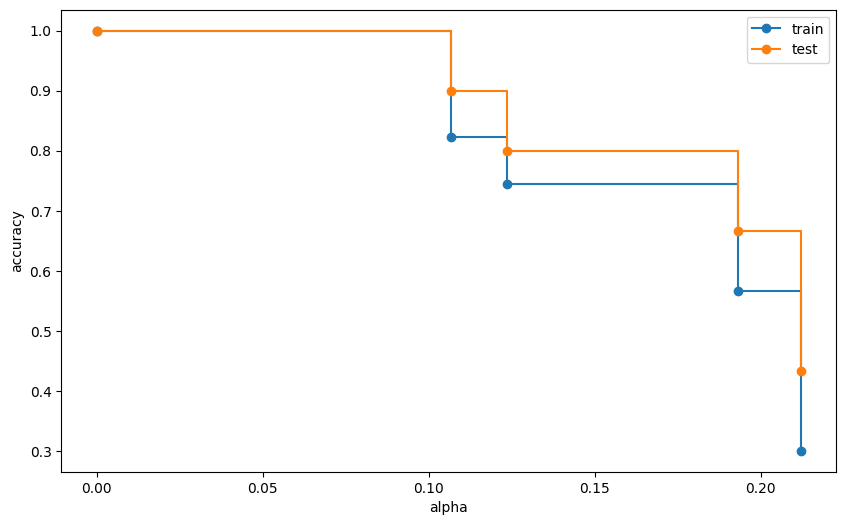

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

path = tree_clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Train a Decision Tree Classifier for each alpha
clfs = []
for alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    
# Evaluate performance of classifiers and choose the best alpha
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_scores, marker='o', label='train', drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores, marker='o', label='test', drawstyle="steps-post")
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.legend()
plt.show()

The optimal alpha is 0 with both highest training and test accuracy. Thus, the pruned tree is same as origin tree.

In [12]:
V_OPTIMAL_CCP_ALPHA = 0
clf = tree.DecisionTreeClassifier()
clf.fit(X, y)
tree_to_pseudo(clf, list(X.columns))

 if ( Lumbar pain <= 0.5 ) {
   if ( Urine pushing <= 0.5 ) {
     return [[10.  0.  0.  0.]]
   } else {
     return [[ 0. 40.  0.  0.]]
   }
 } else {
   if ( Temperature of patient <= 37.95000076293945 ) {
     return [[20.  0.  0.  0.]]
   } else {
     if ( Occurrence of nausea <= 0.5 ) {
       return [[ 0.  0. 21.  0.]]
     } else {
       if ( Urine pushing <= 0.5 ) {
         return [[ 0.  0. 10.  0.]]
       } else {
         return [[ 0.  0.  0. 19.]]
       }
     }
   }
 }


## 2. The LASSO and Boosting for Regression

### (a) Obtain Data

Get the Communities and Crime Data Set

In [13]:
def load_communities_dataset(data_path: str, names_path: str) -> pd.DataFrame:
    """
    Load dataset from 'communities.data' file and name columns.
    Args:
        data_path: string of '.data' file path
        names_path: string of '.names' file path
    Return: dataframe of loaded data
    """
    column_names = []
    
    with open(names_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.split(' ')[0] == '@attribute':
                name = line.split(' ')[1]
                column_names.append(name)
            
    data = pd.read_csv(data_path, header=None).replace('?', np.nan)
    data.columns = column_names
    
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='ignore')
    
    return data

In [14]:
df_communities = load_communities_dataset('../data/communities.data', '../data/communities.names')
print(df_communities)

      state  county  community        communityname  fold  population  \
0         8     NaN        NaN         Lakewoodcity     1        0.19   
1        53     NaN        NaN          Tukwilacity     1        0.00   
2        24     NaN        NaN         Aberdeentown     1        0.00   
3        34     5.0    81440.0  Willingborotownship     1        0.04   
4        42    95.0     6096.0    Bethlehemtownship     1        0.01   
...     ...     ...        ...                  ...   ...         ...   
1989     12     NaN        NaN    TempleTerracecity    10        0.01   
1990      6     NaN        NaN          Seasidecity    10        0.05   
1991      9     9.0    80070.0        Waterburytown    10        0.16   
1992     25    17.0    72600.0          Walthamcity    10        0.08   
1993      6     NaN        NaN          Ontariocity    10        0.20   

      householdsize  racepctblack  racePctWhite  racePctAsian  ...  LandArea  \
0              0.33          0.02          

In [15]:
train_data = df_communities.iloc[0:1495, :]
test_data = df_communities.iloc[1495:, :].reset_index(drop=True)

### (b) Missing values

In [16]:
with open('../data/communities.names', 'r') as file:
    communities_desc = file.read()
    
print(communities_desc)

Title: Communities and Crime

Abstract: Communities within the United States. The data combines socio-economic data 
from the 1990 US Census, law enforcement data from the 1990 US LEMAS survey, and crime 
data from the 1995 FBI UCR.

-----------------------------------------------------------------------------------------

Data Set Characteristics:  Multivariate
Attribute Characteristics: Real
Associated Tasks: Regression
Number of Instances: 1994
Number of Attributes: 128
Missing Values? Yes
Area: Social
Date Donated: 2009-07-13

-----------------------------------------------------------------------------------------

Source:

Creator: Michael Redmond (redmond 'at' lasalle.edu); Computer Science; La Salle 
University; Philadelphia, PA, 19141, USA
-- culled from 1990 US Census, 1995 US FBI Uniform Crime Report, 1990 US Law 
Enforcement Management and Administrative Statistics Survey, available from ICPSR at U 
of Michigan.
-- Donor: Michael Redmond (redmond 'at' lasalle.edu); Computer

According to the Attribute Information, 5 attributes **['state', 'county', 'community', 'communityname', 'fold']** are considered as **not predictive**. Ignore these 5 attributes for data imputation.

Apply **mean** of available data for data imputation.

In [17]:
def mean_imputation(data):
    mean = np.nanmean(data)
    imputed_data = np.where(np.isnan(data), mean, data)
    
    return imputed_data

In [18]:
NONPREDICTIVE_COLUMN_NAMES = ['state', 'county', 'community', 'communityname', 'fold'] 

imputed_train_data = pd.DataFrame()
imputed_test_data = pd.DataFrame()

for col in train_data.columns:
    if col not in NONPREDICTIVE_COLUMN_NAMES:
        imputed_train_data[col] = mean_imputation(train_data[col])
        imputed_test_data[col] = mean_imputation(test_data[col])

/var/folders/xp/36pgtf6s6w1f0hq4cdqf_t180000gn/T/ipykernel_42835/2646421339.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imputed_train_data[col] = mean_imputation(train_data[col])
/var/folders/xp/36pgtf6s6w1f0hq4cdqf_t180000gn/T/ipykernel_42835/2646421339.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imputed_test_data[col] = mean_imputation(test_data[col])
/var/folders/xp/36pgtf6s6w1f0hq4cdqf_t180000gn/T/ipykernel_42835/2646421339.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result 

### (c) Plot a correlation matrix

In [19]:
# Training data
train_corr = imputed_train_data.corr()

train_corr.style.background_gradient(cmap='coolwarm').format(precision=2)

In [20]:
# Test data
test_corr = imputed_test_data.corr()

test_corr.style.background_gradient(cmap='coolwarm').format(precision=2)

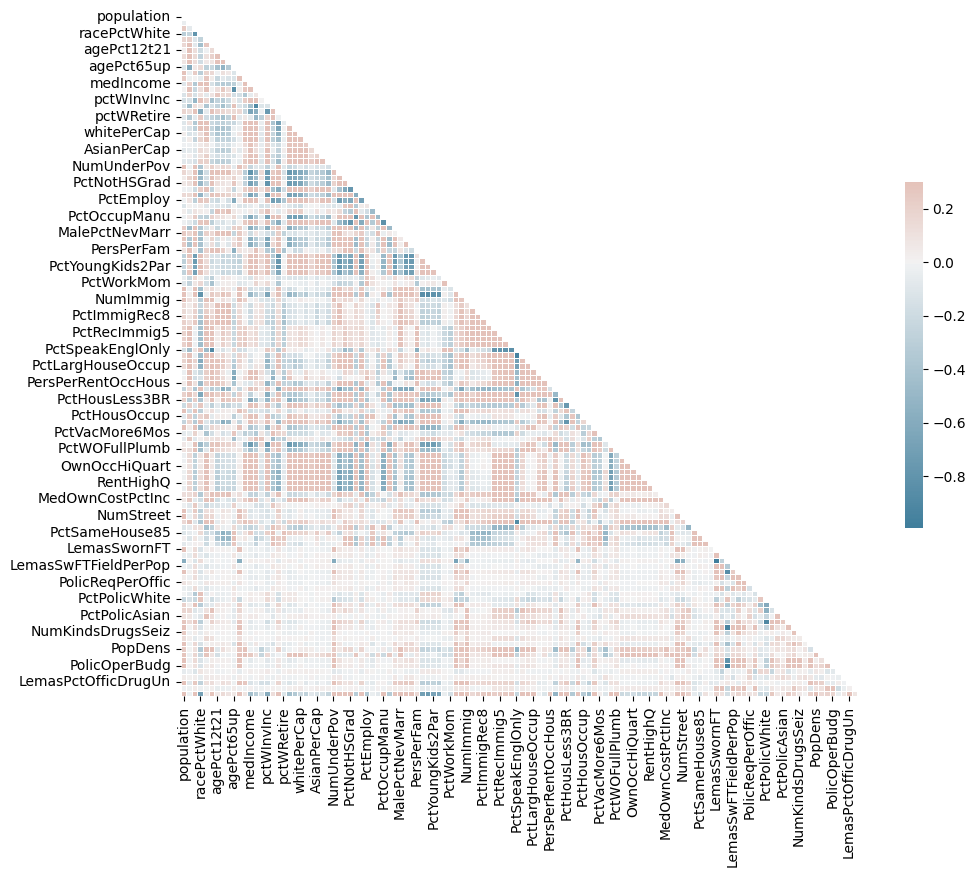

In [21]:
# Apply heatmap to show corrleation matrix
# Generate a mask for the upper triangle (optional)
mask = np.triu(np.ones_like(train_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(train_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

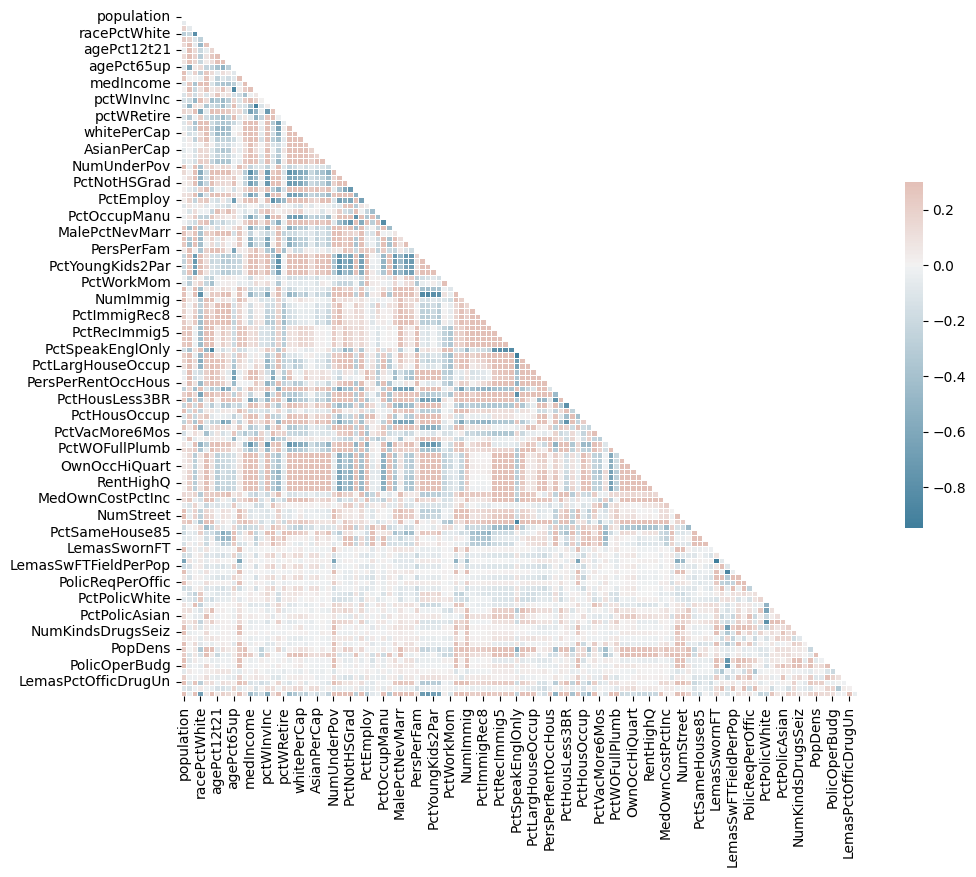

In [22]:
# Generate a mask for the upper triangle (optional)
mask = np.triu(np.ones_like(test_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(test_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

### (d) Calculate the Coefficient of Variation CV

In [23]:
# Concact imputed training data and test data
imputed_data = pd.concat([imputed_train_data, imputed_test_data], axis=0).reset_index(drop=True)
imputed_data_cv = imputed_data\
                            .apply(lambda x: np.std(x, ddof=1) / np.mean(x)).sort_values(ascending=False)

print(imputed_data_cv)

NumStreet              4.407702
NumInShelters          3.485481
NumIlleg               2.994196
NumImmig               2.900497
LemasPctOfficDrugUn    2.555266
                         ...   
NumKindsDrugsSeiz      0.146402
RacialMatchCommPol     0.132428
LemasPctPolicOnPatr    0.126642
PctPolicWhite          0.121712
LemasSwFTFieldOps      0.057906
Length: 123, dtype: float64


### (e) Scatter plots and box plots for highest CV features

In [24]:
# Select ⌊128⌋ features with highest CV
N_FEATURES = math.floor(np.sqrt(128))

selected_feature = list(imputed_data_cv.head(N_FEATURES).index)
print(selected_feature)

['NumStreet', 'NumInShelters', 'NumIlleg', 'NumImmig', 'LemasPctOfficDrugUn', 'NumUnderPov', 'population', 'numbUrban', 'HousVacant', 'LandArea', 'racePctHisp']


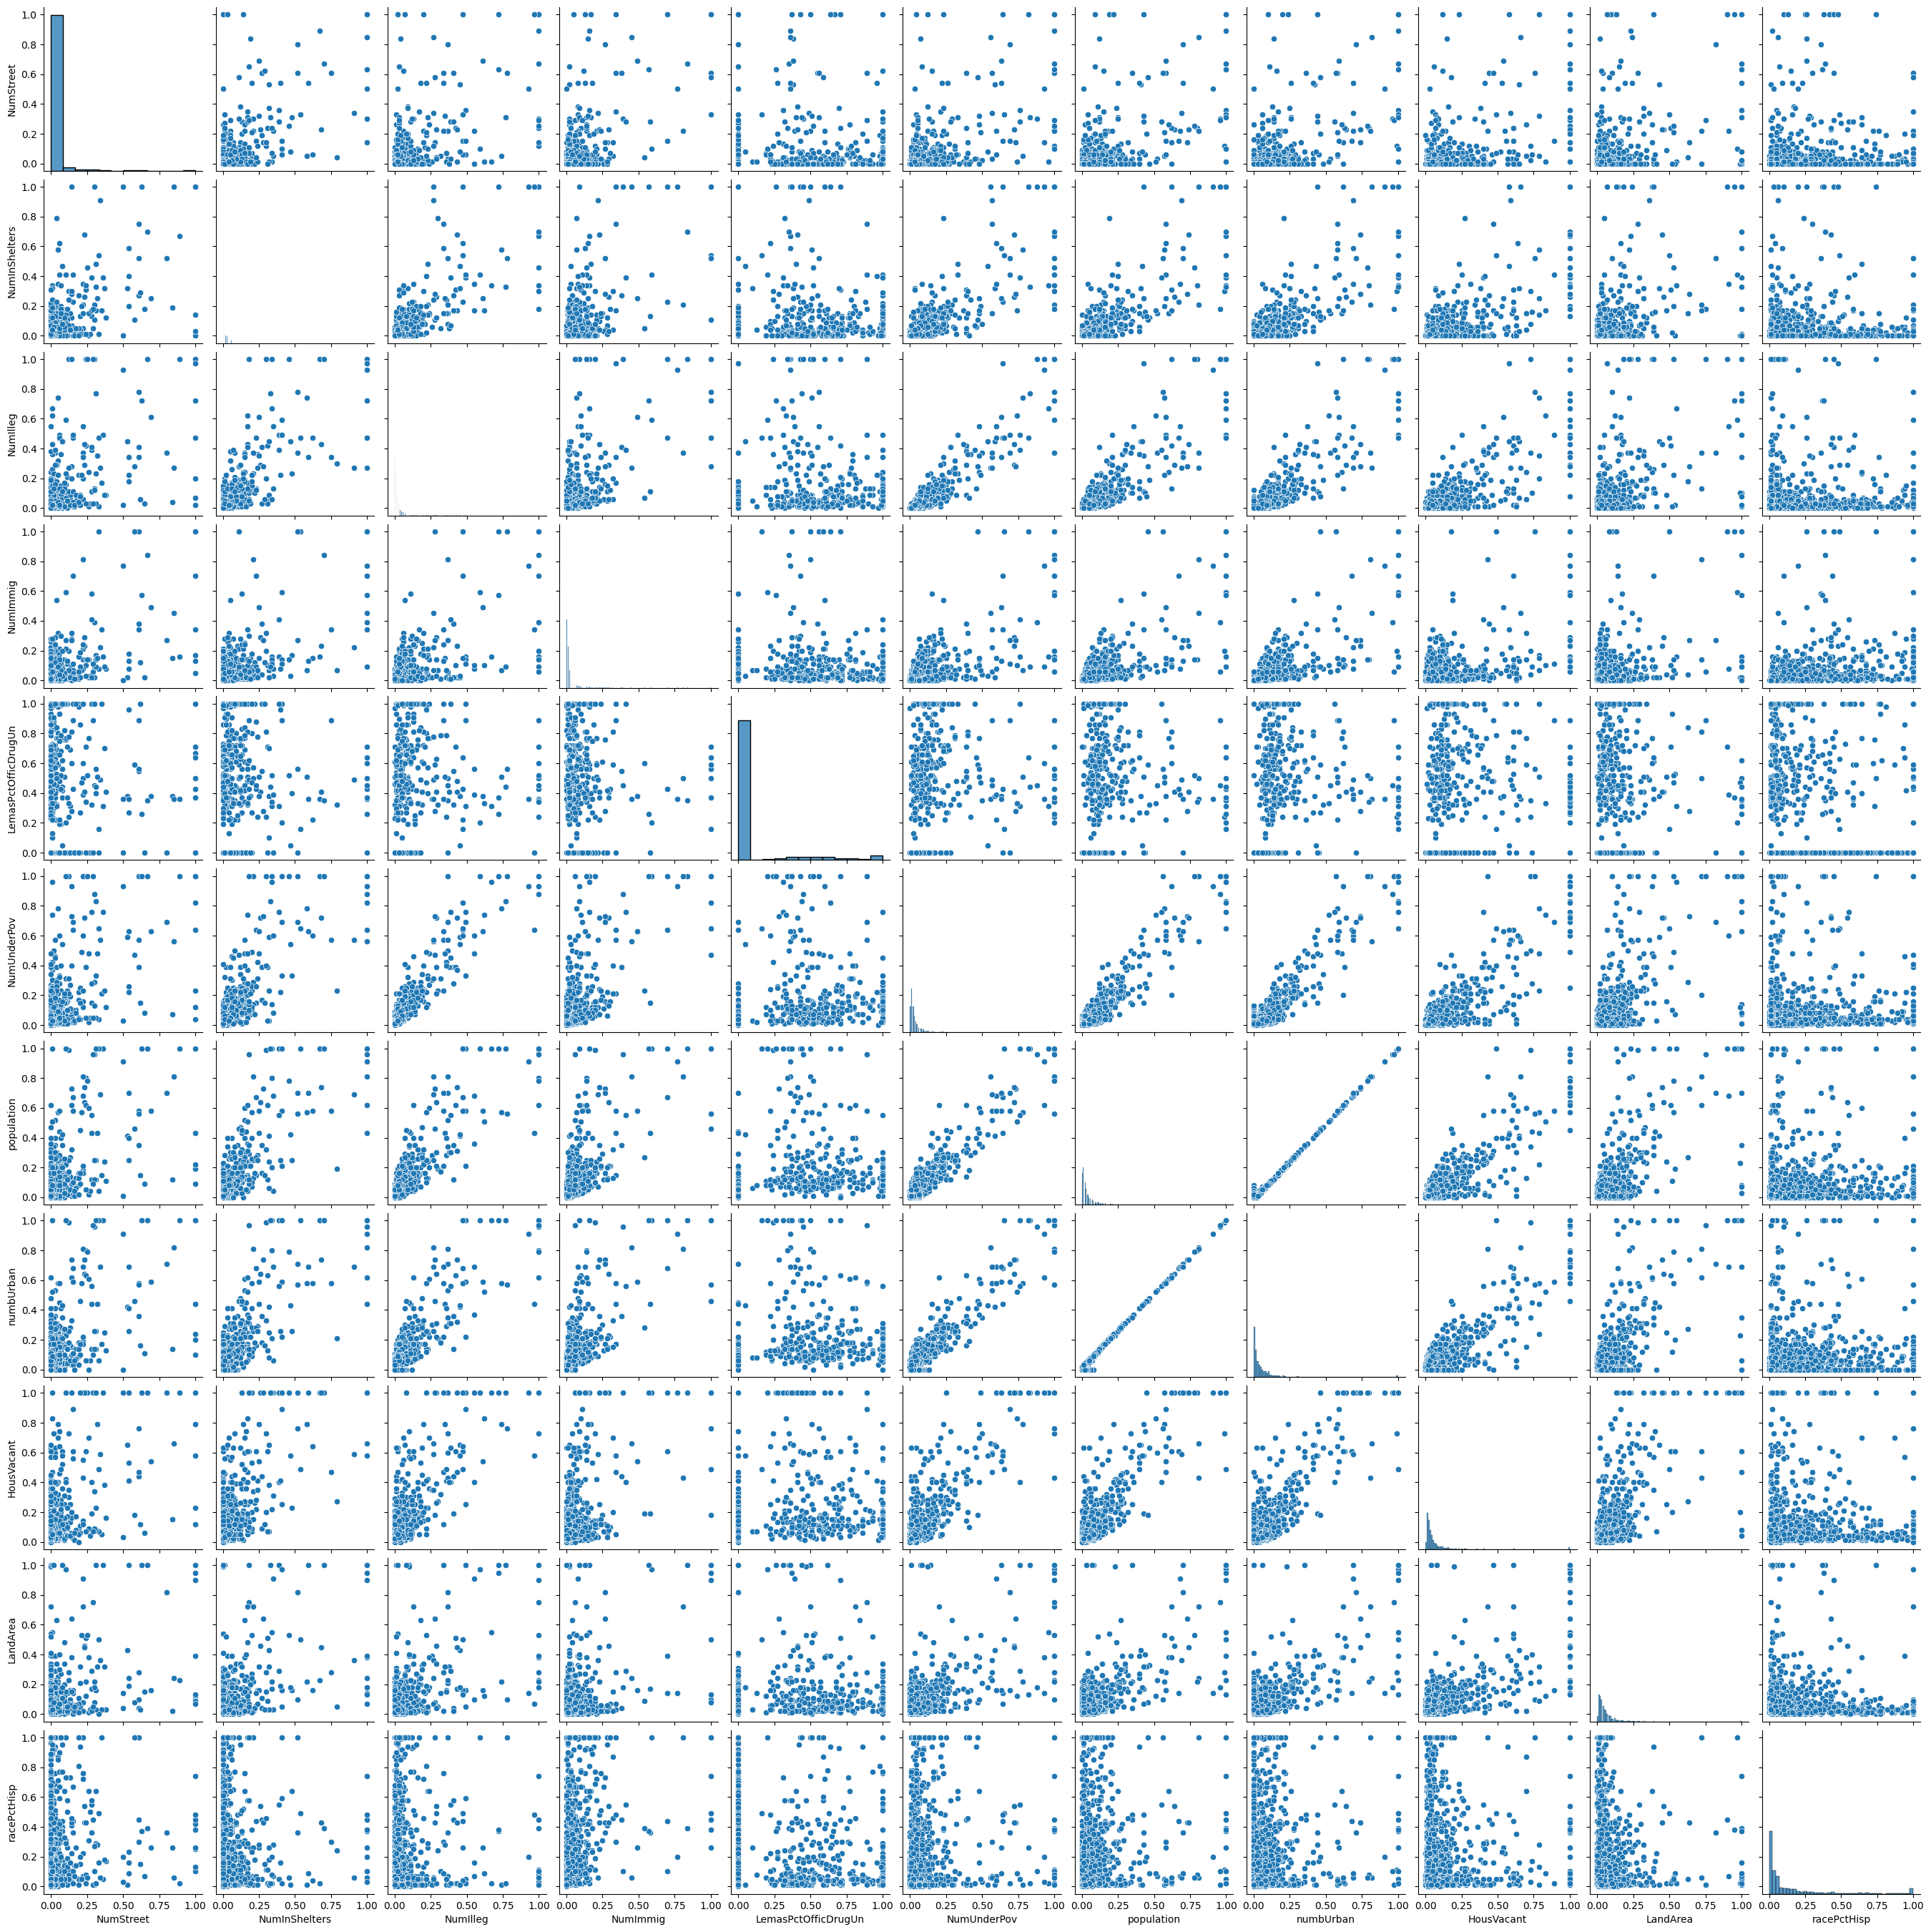

In [25]:
# Plot scatter plot for selected features
warnings.filterwarnings('ignore')
sns.pairplot(imputed_data[selected_feature])
plt.show()

Many of scatter plots show similar patterns. For example, scatter plots of ['NumStreet', 'NumInShelters'], ['NumStreet', 'NumIlleg'], and ['NumberStreet', 'NumImmig'] show similar patterns, which reveals the similarity among 'NumInShelters', 'NumIlleg', 'NumImmig'.

### (f) Fit a linear model

In [26]:
C_RESPONSE_VARIABLE = "ViolentCrimesPerPop"

X_train = imputed_train_data.drop(columns=[C_RESPONSE_VARIABLE])
y_train = imputed_train_data[C_RESPONSE_VARIABLE]
X_test = imputed_test_data[list(X_train.columns)]
y_test = imputed_test_data[C_RESPONSE_VARIABLE]

In [27]:
linear_regresson_model = linear_model.LinearRegression()
linear_regresson_model.fit(X_train, y_train)
print("Test MSE of linear model:", mean_squared_error(y_test, linear_regresson_model.predict(X_test)))

Test MSE of linear model: 1.6253459095780234e+18


### (g) Fit a ridge regression model

Ref: 

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html

Aplpha in sklearn.linear_model.RidgeCV represents lambda

In [28]:
# Choose optimal 𝜆 by 5-folds cross-validation
# 𝜆 ranges from 10^-6 to 10^6
alphas = np.logspace(-6, 6, 13)

# Set up the 5-folds cross-validation
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

# Create a custom scorer for MSE
mse_scorer = make_scorer(mean_squared_error)

# Loop through each alpha and compute average MSE of 5 folds
alpha_ridge_mse_list = []

for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha)
    mse_scores = cross_val_score(ridge, X_train, y_train, cv=cv_strategy, scoring=mse_scorer)  
    mean_mse = mse_scores.mean()
    alpha_ridge_mse_list.append(mean_mse)
    print(f"Lambda: {alpha}, Mean MSE: {mean_mse:.4f}")

V_OPTIMAL_RIDGE_LAMBDA = alphas[np.argmin(alpha_ridge_mse_list)]
print(f"\nOptimal lambda with minimum MSE: {V_OPTIMAL_RIDGE_LAMBDA}")

Lambda: 1e-06, Mean MSE: 0.0208
Lambda: 1e-05, Mean MSE: 0.0208
Lambda: 0.0001, Mean MSE: 0.0208
Lambda: 0.001, Mean MSE: 0.0208
Lambda: 0.01, Mean MSE: 0.0206
Lambda: 0.1, Mean MSE: 0.0202
Lambda: 1.0, Mean MSE: 0.0196
Lambda: 10.0, Mean MSE: 0.0195
Lambda: 100.0, Mean MSE: 0.0210
Lambda: 1000.0, Mean MSE: 0.0320
Lambda: 10000.0, Mean MSE: 0.0507
Lambda: 100000.0, Mean MSE: 0.0559
Lambda: 1000000.0, Mean MSE: 0.0565

Optimal lambda with minimum MSE: 10.0


In [29]:
ridge_regression_model = linear_model.Ridge(alpha=V_OPTIMAL_RIDGE_LAMBDA)
ridge_regression_model.fit(X_train, y_train)
print("Test MSE of ridge model:", mean_squared_error(y_test, ridge_regression_model.predict(X_test)))

Test MSE of ridge model: 0.01743308917459929


### (h) Fit a LASSO model

#### Original Features

In [30]:
# Loop through each alpha and compute average MSE of 5 folds
alpha_lasso_mse_list = []

for alpha in alphas:
    lasso = linear_model.Lasso(alpha=alpha, max_iter=10000)
    mse_scores = cross_val_score(lasso, X_train, y_train, cv=cv_strategy, scoring=mse_scorer)  
    mean_mse = mse_scores.mean()
    alpha_lasso_mse_list.append(mean_mse)
    print(f"Lambda: {alpha}, Mean MSE: {mean_mse:.4f}")

V_OPTIMAL_LASSO_LAMBDA = alphas[np.argmin(alpha_lasso_mse_list)]
print(f"\nOptimal lambda with minimum MSE: {V_OPTIMAL_LASSO_LAMBDA}")

Lambda: 1e-06, Mean MSE: 0.0207
Lambda: 1e-05, Mean MSE: 0.0204
Lambda: 0.0001, Mean MSE: 0.0195
Lambda: 0.001, Mean MSE: 0.0198
Lambda: 0.01, Mean MSE: 0.0246
Lambda: 0.1, Mean MSE: 0.0566
Lambda: 1.0, Mean MSE: 0.0566
Lambda: 10.0, Mean MSE: 0.0566
Lambda: 100.0, Mean MSE: 0.0566
Lambda: 1000.0, Mean MSE: 0.0566
Lambda: 10000.0, Mean MSE: 0.0566
Lambda: 100000.0, Mean MSE: 0.0566
Lambda: 1000000.0, Mean MSE: 0.0566

Optimal lambda with minimum MSE: 0.0001


In [31]:
lasso_regression_model = linear_model.Lasso(alpha=V_OPTIMAL_LASSO_LAMBDA)
lasso_regression_model.fit(X_train, y_train)
print("Test MSE of LASSO model:", mean_squared_error(y_test, lasso_regression_model.predict(X_test)))

Test MSE of LASSO model: 0.01776646555537784


In [32]:
# Extract the coefficients of the LASSO model
coefficients = lasso_regression_model.coef_

# Identify and print the selected features
lasso_selected_features = X_train.columns[coefficients != 0].tolist()
lasso_selected_coefficients = coefficients[coefficients != 0]

print(f"{len(lasso_selected_features)} Selected Features by LASSO and Corresponding Coefficients:")
for feature, coef in zip(lasso_selected_features, lasso_selected_coefficients):
    print(f"{feature}: {coef:.4f}")

78 Selected Features by LASSO and Corresponding Coefficients:
racepctblack: 0.2731
racePctAsian: -0.0180
agePct12t21: 0.0760
agePct12t29: -0.2911
agePct65up: 0.0039
pctUrban: 0.0410
pctWWage: -0.0932
pctWFarmSelf: 0.0291
pctWInvInc: -0.1101
pctWSocSec: 0.0592
pctWPubAsst: 0.0418
pctWRetire: -0.1098
whitePerCap: -0.0695
blackPerCap: -0.0225
indianPerCap: -0.0319
AsianPerCap: 0.0292
OtherPerCap: 0.0236
HispPerCap: 0.0257
PctPopUnderPov: -0.1501
PctLess9thGrade: -0.0213
PctBSorMore: 0.0173
PctEmploy: 0.1550
PctEmplManu: -0.0192
PctOccupManu: 0.0165
MalePctDivorce: 0.1326
MalePctNevMarr: 0.1507
FemalePctDiv: -0.0956
PctKids2Par: -0.1981
PctYoungKids2Par: -0.0360
PctTeen2Par: -0.0115
PctWorkMom: -0.1347
NumIlleg: -0.0623
PctIlleg: 0.0956
NumImmig: -0.0812
PctImmigRec10: -0.0056
PctRecImmig10: 0.0393
PctNotSpeakEnglWell: -0.0808
PctLargHouseOccup: -0.0895
PersPerOccupHous: 0.0733
PctPersOwnOccup: -0.0644
PctPersDenseHous: 0.2311
PctHousLess3BR: 0.0649
MedNumBR: 0.0060
HousVacant: 0.1303
PctH

#### Standardized Features

In [33]:
# Standardize features
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.fit_transform(X_test)

# Loop through each alpha and compute average MSE of 5 folds
alpha_stand_lasso_mse_list = []

for alpha in alphas:
    lasso = linear_model.Lasso(alpha=alpha, max_iter=11000)
    mse_scores = cross_val_score(lasso, X_train_standardized, y_train, cv=cv_strategy, scoring=mse_scorer)  
    mean_mse = mse_scores.mean()
    alpha_stand_lasso_mse_list.append(mean_mse)
    print(f"Lambda: {alpha}, Mean MSE: {mean_mse:.4f}")

V_OPTIMAL_STAND_LASSO_LAMBDA = alphas[np.argmin(alpha_stand_lasso_mse_list)]
print(f"\nOptimal lambda with minimum MSE: {V_OPTIMAL_STAND_LASSO_LAMBDA}")

Lambda: 1e-06, Mean MSE: 0.0208
Lambda: 1e-05, Mean MSE: 0.0207
Lambda: 0.0001, Mean MSE: 0.0204
Lambda: 0.001, Mean MSE: 0.0197
Lambda: 0.01, Mean MSE: 0.0203
Lambda: 0.1, Mean MSE: 0.0340
Lambda: 1.0, Mean MSE: 0.0566
Lambda: 10.0, Mean MSE: 0.0566
Lambda: 100.0, Mean MSE: 0.0566
Lambda: 1000.0, Mean MSE: 0.0566
Lambda: 10000.0, Mean MSE: 0.0566
Lambda: 100000.0, Mean MSE: 0.0566
Lambda: 1000000.0, Mean MSE: 0.0566

Optimal lambda with minimum MSE: 0.001


In [34]:
stand_lasso_regression_model = linear_model.Lasso(alpha=V_OPTIMAL_STAND_LASSO_LAMBDA)
stand_lasso_regression_model.fit(X_train_standardized, y_train)
print("Test MSE of LASSO model with standardized features:", mean_squared_error(y_test,\
                                                     stand_lasso_regression_model.predict(X_test_standardized)))

Test MSE of LASSO model with standardized features: 0.0179550520850434


In [35]:
# Extract the coefficients of the LASSO model
coefficients = stand_lasso_regression_model.coef_

# Identify and print the selected features
stand_lasso_selected_features = X_train.columns[coefficients != 0].tolist()
stand_lasso_selected_coefficients = coefficients[coefficients != 0]

print(f"{len(stand_lasso_selected_features)} Selected Features by LASSO and Corresponding Coefficients:")
for feature, coef in zip(stand_lasso_selected_features, stand_lasso_selected_coefficients):
    print(f"{feature}: {coef:.4f}")

68 Selected Features by LASSO and Corresponding Coefficients:
racepctblack: 0.0668
agePct12t21: 0.0053
agePct12t29: -0.0286
pctUrban: 0.0157
pctWWage: -0.0088
pctWFarmSelf: 0.0029
pctWInvInc: -0.0181
pctWSocSec: 0.0068
pctWPubAsst: 0.0035
pctWRetire: -0.0157
whitePerCap: -0.0041
blackPerCap: -0.0031
indianPerCap: -0.0050
AsianPerCap: 0.0049
OtherPerCap: 0.0034
HispPerCap: 0.0031
PctPopUnderPov: -0.0210
PctLess9thGrade: -0.0002
PctEmploy: 0.0143
PctEmplManu: -0.0002
MalePctDivorce: 0.0151
MalePctNevMarr: 0.0151
FemalePctDiv: -0.0024
PctKids2Par: -0.0396
PctYoungKids2Par: -0.0088
PctTeen2Par: -0.0006
PctWorkMom: -0.0192
NumIlleg: -0.0016
PctIlleg: 0.0255
NumImmig: -0.0064
PctImmigRec5: -0.0006
PctRecImmig10: 0.0043
PctNotSpeakEnglWell: -0.0032
PctLargHouseOccup: -0.0000
PctPersOwnOccup: -0.0065
PctPersDenseHous: 0.0333
PctHousLess3BR: 0.0087
HousVacant: 0.0160
PctHousOccup: -0.0117
PctVacantBoarded: 0.0137
PctVacMore6Mos: -0.0088
MedYrHousBuilt: -0.0021
PctWOFullPlumb: -0.0039
RentLowQ: 

Comparsion between original features and normalized features:

|                             | Original | Standardized |
|-----------------------------|----------|--------------|
| Test MSE                    | 0.0178   | 0.0180       |
| Number of selected features | 78       | 68           |

In this case, standardization doesn't help decrease test error.

### (i) Fit a PCR model

In [36]:
# Determine the number of components for PCA
n_components_array = np.arange(1, X_train.shape[1] + 1)  # 1 to number of features
pca_mse_scores = []

for n_components in n_components_array:
    pca = PCA(n_components)
    X_train_pca = pca.fit_transform(X_train)
    LR = linear_model.LinearRegression()
    mse_scores = cross_val_score(LR, X_train_pca, y_train, cv=cv_strategy, scoring=mse_scorer)  
    mean_mse = mse_scores.mean()
    pca_mse_scores.append(mean_mse)
    print(f"Number of components: {n_components}, Mean MSE: {mean_mse:.4f}")
    
    
V_OPTIMAL_N_COMPONENTS = n_components_array[np.argmin(pca_mse_scores)]
print(f"\nOptimal number of components in PCA with minimum MSE: {V_OPTIMAL_N_COMPONENTS}")

Number of components: 1, Mean MSE: 0.0381
Number of components: 2, Mean MSE: 0.0310
Number of components: 3, Mean MSE: 0.0279
Number of components: 4, Mean MSE: 0.0246
Number of components: 5, Mean MSE: 0.0233
Number of components: 6, Mean MSE: 0.0228
Number of components: 7, Mean MSE: 0.0203
Number of components: 8, Mean MSE: 0.0204
Number of components: 9, Mean MSE: 0.0203
Number of components: 10, Mean MSE: 0.0202
Number of components: 11, Mean MSE: 0.0203
Number of components: 12, Mean MSE: 0.0203
Number of components: 13, Mean MSE: 0.0202
Number of components: 14, Mean MSE: 0.0202
Number of components: 15, Mean MSE: 0.0203
Number of components: 16, Mean MSE: 0.0203
Number of components: 17, Mean MSE: 0.0204
Number of components: 18, Mean MSE: 0.0204
Number of components: 19, Mean MSE: 0.0204
Number of components: 20, Mean MSE: 0.0205
Number of components: 21, Mean MSE: 0.0205
Number of components: 22, Mean MSE: 0.0205
Number of components: 23, Mean MSE: 0.0202
Number of components

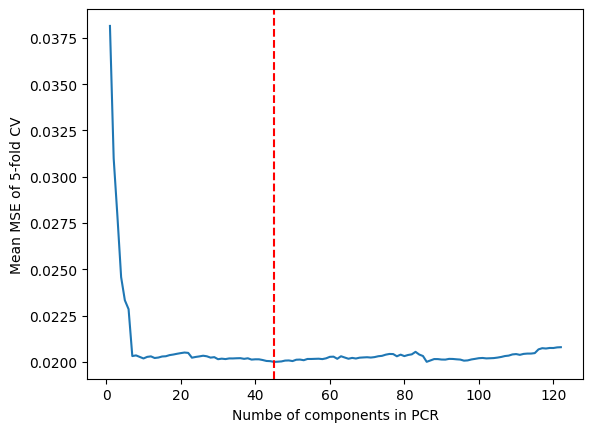

In [37]:
# Plot the trend of average MSE of CV while number of components increases
plt.plot(n_components_array, pca_mse_scores)
plt.axvline(V_OPTIMAL_N_COMPONENTS, color='r', linestyle='--', label='optimal M')
plt.xlabel("Numbe of components in PCR")
plt.ylabel("Mean MSE of 5-fold CV")
plt.show()

In [38]:
# Fit PCR model with optimal number of components
pca_model = PCA(V_OPTIMAL_N_COMPONENTS)
X_train_pca = pca_model.fit_transform(X_train)
X_test_pca = pca_model.transform(X_test)

LR_model = linear_model.LinearRegression()
LR_model.fit(X_train_pca, y_train)
print("Test MSE of Linear Regression with PCA:", mean_squared_error(y_test, LR_model.predict(X_test_pca)))

Test MSE of Linear Regression with PCA: 0.0183067598878809


### (j) Fit a boosting tree

Due to the operation system version, I could not install the latest XGBoost package.

Thus, I referred to the below guide to install xgboost-1.4.2. I used Method 2: Using setup.py to install XGBoost in the below guid.

https://www.geeksforgeeks.org/how-to-install-xgboost-and-lightgbm-on-macos/

In [39]:
alpha_xgb_mse_list = []

for alpha in alphas:
    cv_mse_list = []
    for train_index,val_index in cv_strategy.split(X_train):
        X_CV_train, X_CV_val = X_train.iloc[train_index.tolist(),:], X_train.iloc[val_index.tolist(),:]
        y_CV_train, y_CV_val = np.array(y_train)[train_index.tolist()], np.array(y_train)[val_index.tolist()]
        xgb = XGBRegressor(random_state=42, reg_alpha=alpha)
        xgb.fit(X_CV_train.values, y_CV_train)
        cv_mse_list.append(mean_squared_error(y_CV_val, xgb.predict(X_CV_val)))
        
    mean_mse = sum(cv_mse_list) / len(cv_mse_list)
    alpha_xgb_mse_list.append(mean_mse)
    print(f"Lambda: {alpha}, Mean MSE: {mean_mse:.4f}")
    
    
V_OPTIMAL_BOOST_LAMBDA = alphas[np.argmin(alpha_xgb_mse_list)]
print(f"\nOptimal lambda with minimum MSE: {V_OPTIMAL_BOOST_LAMBDA}")

Lambda: 1e-06, Mean MSE: 0.0230
Lambda: 1e-05, Mean MSE: 0.0229
Lambda: 0.0001, Mean MSE: 0.0232
Lambda: 0.001, Mean MSE: 0.0233
Lambda: 0.01, Mean MSE: 0.0227
Lambda: 0.1, Mean MSE: 0.0229
Lambda: 1.0, Mean MSE: 0.0223
Lambda: 10.0, Mean MSE: 0.0227
Lambda: 100.0, Mean MSE: 0.0377
Lambda: 1000.0, Mean MSE: 0.1237
Lambda: 10000.0, Mean MSE: 0.1237
Lambda: 100000.0, Mean MSE: 0.1237
Lambda: 1000000.0, Mean MSE: 0.1237

Optimal lambda with minimum MSE: 1.0


In [40]:
xgb_model = XGBRegressor(random_state=42, reg_alpha=V_OPTIMAL_BOOST_LAMBDA)
xgb_model.fit(X_train.values, y_train)
print("Test MSE of XGBoost:", mean_squared_error(y_test, xgb_model.predict(X_test.values)))

Test MSE of XGBoost: 0.017432515156236016
